# Dropout _ A Simple Way to Prevent Neural Networks from Overfitting

## 0. Paper

### Info
* TItle : Dropout _ A Simple Way to Prevent Neural Networks from Overfitting
* Author : Nitish Srivastava et al.
* Link : https://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf

### Summary
* 학습 과정에서 일정 확률로 파라미터를 drop 시킴
* ensemble 기능을 함으로써 overfitting 방지

### Differences
* ##

## 1. Setting

In [ ]:
# Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa

In [ ]:
# Hyperparameters
CONFIG = {
    'base_dir' : '/content/drive/Shared drives/Yoon/Project/Doing/Deep Learning Paper Implementation',
    'batch_size' : 128,
    'epoch_size' : 50
}

## 2. Data

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [ ]:
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

## 3. Model

In [ ]:
class DropoutLayer(tf.keras.layers.Layer):
    def __init__(self, drop_rate):
        super(DropoutLayer, self).__init__()
        self.drop_rate = drop_rate

    def call(self, x, training=False):
        if training:
            mask_shape = x.shape
            if not mask_shape[0]:
                mask_shape = [1] + list(mask_shape[1:])
            drop_mask = tf.keras.backend.random_bernoulli(mask_shape, p=1-self.drop_rate, dtype=tf.float32)
            x *= drop_mask
        else:
            x *= 1 - self.drop_rate
        return x

In [ ]:
class ModelDropout(tf.keras.Model):
    def __init__(self):
        super(ModelDropout, self).__init__()

        self.dropout1 = DropoutLayer(0.1)
        self.conv1 = tf.keras.layers.Conv2D(96, 5, padding='same', activation='relu')
        self.pool1 = tf.keras.layers.MaxPool2D(3, 2)
        self.dropout2 = DropoutLayer(0.25)
        self.conv2 = tf.keras.layers.Conv2D(128, 5, padding='same', activation='relu')
        self.pool2 = tf.keras.layers.MaxPool2D(3, 2)
        self.dropout3 = DropoutLayer(0.25)
        self.conv3 = tf.keras.layers.Conv2D(256, 5, padding='same', activation='relu')
        self.pool3 = tf.keras.layers.MaxPool2D(3, 2)
        self.dropout4 = DropoutLayer(0.5)

        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(2048, activation='relu')
        self.dropout5 = DropoutLayer(0.5)
        self.fc2 = tf.keras.layers.Dense(2048, activation='relu')
        self.dropout6 = DropoutLayer(0.5)
        self.fc3 = tf.keras.layers.Dense(10, activation='softmax')
    
    def call(self, x ,training):
        x = self.dropout1(x, training=training)
        x = self.pool1(self.conv1(x))
        x = self.dropout2(x, training=training)
        x = self.pool2(self.conv2(x))
        x = self.dropout3(x, training=training)
        x = self.pool3(self.conv3(x))
        x = self.dropout4(x, training=training)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout5(x, training=training)
        x = self.fc2(x)
        x = self.dropout6(x, training=training)
        x = self.fc3(x)
        return x

class ModelNODropout(tf.keras.Model):
    def __init__(self):
        super(ModelNODropout, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(96, 5, padding='same', activation='relu')
        self.pool1 = tf.keras.layers.MaxPool2D(3, 2)
        self.conv2 = tf.keras.layers.Conv2D(128, 5, padding='same', activation='relu')
        self.pool2 = tf.keras.layers.MaxPool2D(3, 2)
        self.conv3 = tf.keras.layers.Conv2D(256, 5, padding='same', activation='relu')
        self.pool3 = tf.keras.layers.MaxPool2D(3, 2)

        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(2048, activation='relu')
        self.fc2 = tf.keras.layers.Dense(2048, activation='relu')
        self.fc3 = tf.keras.layers.Dense(10, activation='softmax')
    
    def call(self, x ,training):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.pool3(self.conv3(x))

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

## 4. Train

In [ ]:
model_no_dropout = ModelNODropout()
model_no_dropout.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['acc']
)

In [ ]:
hist_no_dropout = model_no_dropout.fit(
    x_train, y_train,
    batch_size = CONFIG['batch_size'],
    epochs = CONFIG['epoch_size']
)

In [ ]:
model_dropout = ModelDropout()
model_dropout.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['acc']
)

In [ ]:
hist_dropout = model_dropout.fit(
    x_train, y_train,
    batch_size = CONFIG['batch_size'],
    epochs = CONFIG['epoch_size']
)

## 5. Test

In [ ]:
loss_no_dropout, acc_no_dropout = model_no_dropout.evaluate(x_test, y_test, batch_size=CONFIG['batch_size'])
loss_dropout, acc_dropout = model_dropout.evaluate(x_test, y_test, batch_size=CONFIG['batch_size'])

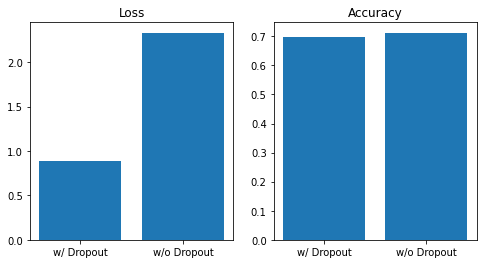

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

ax[0].bar(x=['w/ Dropout', 'w/o Dropout'], height=[loss_dropout, loss_no_dropout])
ax[0].set_title('Loss')

ax[1].bar(x=['w/ Dropout', 'w/o Dropout'], height=[acc_dropout, acc_no_dropout])
ax[1].set_title('Accuracy')

plt.show()